# 1. Generate Analysts: Human-in-the-loop

In [41]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [42]:
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst"
    )
    name: str = Field(
        description="Name of the analyst"
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic"
    )
    description: str = Field(
        description="Description of the analyst focus, concerns and motives."
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n" 
    
    
class Perspectives(BaseModel):
    analysts: list[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations"
    )

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: list[Analyst]   

In [43]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [44]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:
1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.
"""

def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get('human_analyst_feedback', '')
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_message = analyst_instructions.format(
        topic=topic, 
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )
    
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")]
    )
    return {"analysts": analysts.analysts}


def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback is not None:
        return "create_analysts"
    
    return END

In [45]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:
1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.
"""

structured_llm = llm.with_structured_output(Perspectives)
max_analysts = 3
topic = '''The benefits of adopting LangGraph as an agent framework'''
thread = {"configurable": {"thread_id": 1}}

system_message = analyst_instructions.format(
    topic=topic, 
    human_analyst_feedback="",
    max_analysts=max_analysts,
)

analysts = structured_llm.invoke(
    [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")]
)

In [59]:
analysts.analysts

[Analyst(affiliation='AI Research Institute', name='Dr. Alice Johnson', role='AI Framework Specialist', description='Dr. Johnson focuses on the technical advantages of LangGraph, emphasizing its modular architecture and how it compares to existing frameworks. Her motive is to address the scalability of AI models and the ease of integration with other tools.'),
 Analyst(affiliation='Tech Industry Consortium', name='Mr. Jeremy Lee', role='Industry Applications Analyst', description='Mr. Lee explores the practical implications of adopting LangGraph in various industries, focusing on real-world case studies and potential ROI. His concerns center around the adaptability of the framework for different business needs.'),
 Analyst(affiliation='Data Science Academia', name='Prof. Linda Martinez', role='Ethics and Governance Researcher', description='Prof. Martinez evaluates the ethical implications of using LangGraph as an agent framework, particularly in data privacy and algorithmic accountabi

In [68]:
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    should_continue,
    ["create_analysts", END],
)

# memory = MemorySaver()
# graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

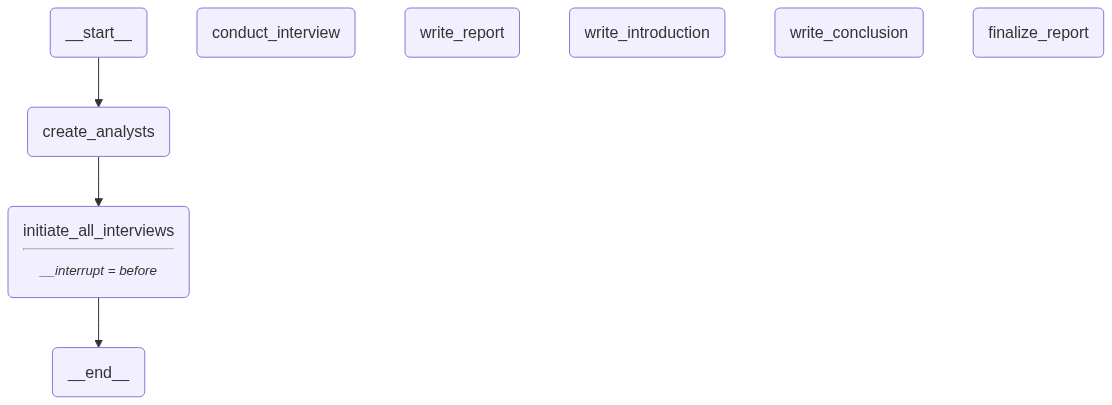

In [69]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
max_analysts = 3
topic = '''The benefits of adopting LangGraph as an agent framework'''
thread = {"configurable": {"thread_id": 1}}


for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts},
    thread,
    stream_mode="values",    
):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name; {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name; Dr. Sarah Lin
Affiliation: Tech Research Institute
Role: AI Framework Specialist
Description: Expert in AI frameworks and their implementation in various industries, Dr. Lin focuses on how LangGraph can improve efficiency and scalability in AI systems.
--------------------------------------------------
Name; Michael Chen
Affiliation: AI Development Hub
Role: Software Architect
Description: A software architect specializing in agent-based systems, Michael explores the technical advantages of adopting LangGraph over traditional frameworks, emphasizing integration and performance.
--------------------------------------------------
Name; Prof. Emily Rivera
Affiliation: Data Science Academy
Role: Data Analyst and Educator
Description: With a background in data analytics and machine learning, Prof. Rivera investigates the learning and adaptation capabilities of LangGraph, particularly its impact on data-driven decision making.
--------------------------------------------------


In [71]:
state = graph.get_state(thread)
state.next

('initiate_all_interviews',)

In [72]:
# graph.update_state(
#     thread, 
#     {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"},
#     as_node="human_feedback",
# )

In [73]:
# for event in graph.stream(None, thread, stream_mode="values"):
#     print(event.get("topic"))
#     analysts = event.get('analysts', '')
#     if analysts:
#         for analyst in analysts:
#             print(f"Name; {analyst.name}")
#             print(f"Affiliation: {analyst.affiliation}")
#             print(f"Role: {analyst.role}")
#             print(f"Description: {analyst.description}")
#             print("-" * 50)

In [74]:
for i in graph.get_state_history(thread):
    print(i.values)

{'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Tech Research Institute', name='Dr. Sarah Lin', role='AI Framework Specialist', description='Expert in AI frameworks and their implementation in various industries, Dr. Lin focuses on how LangGraph can improve efficiency and scalability in AI systems.'), Analyst(affiliation='AI Development Hub', name='Michael Chen', role='Software Architect', description='A software architect specializing in agent-based systems, Michael explores the technical advantages of adopting LangGraph over traditional frameworks, emphasizing integration and performance.'), Analyst(affiliation='Data Science Academy', name='Prof. Emily Rivera', role='Data Analyst and Educator', description='With a background in data analytics and machine learning, Prof. Rivera investigates the learning and adaptation capabilities of LangGraph, particularly its impact on data-driven decision making.')], 'sectio

# Conduct Interview

In [75]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

In [76]:
class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search Query for retrieval")

In [77]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """
    
    # Get State
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_messages = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_messages)] + messages)
    
    return {"messages": [question]}

# Generate Answers: Parallelization

In [78]:
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
tavily_search = TavilySearch(max_results=3)

In [79]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")


def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    
    search_docs = tavily_search.invoke(search_query.search_query)
    
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )
    
    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    
    search_docs = WikipediaLoader(
        query=search_query.search_query,
        load_max_docs=2,
    ).load()
    
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}

In [80]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    """ Node to answer a question """
    
    analyst = state["analyst"]
    context = state["context"]
    messages = state["messages"]
    
    system_messages = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_messages)] + messages)
    
    answer.name = "expert"
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """ Save interviews """
    
    messages = state["messages"]
    interview = get_buffer_string(messages)
    
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """
    
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)
    
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    
    if num_responses >= max_num_turns:
        return "save_interview"
    
    last_messages = messages[-2]
    if "Thank you so much for your help" in last_messages:
        return "save_interview"
    else:
        return "ask_question"

In [81]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    """ Node to answer a question """
    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
    
    return {"sections": [section.content]}           

In [82]:
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question",
    route_messages,
    ["ask_question", "save_interview"],
)
interview_builder.add_edge("save_interview", "write_section")
# interview_builder.add_edge("write_section", END)

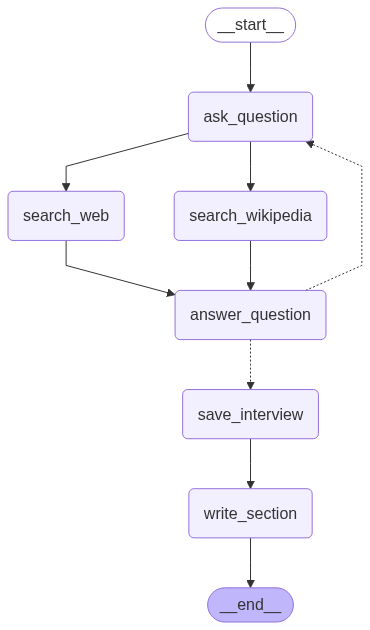

In [83]:
memory = MemorySaver()
graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")
display(Image(graph.get_graph().draw_mermaid_png()))

In [84]:
topic = "The benefits of adopting LangGraph as an agent framework"
messages = [HumanMessage(content=f"So you said you were writing an article on {topic}")]
thread = {"configurable": {"thread_id": "1"}}
interview = graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)

KeyboardInterrupt: 

In [ ]:
from IPython.display import Markdown
Markdown(interview['sections'][0])

## Enhancing AI Model Interoperability with LangGraph

### Summary
In the rapidly evolving landscape of artificial intelligence, the effectiveness of AI models greatly depends on their interoperability and ability to manage complex workflows. LangGraph emerges as a powerful framework designed to facilitate advanced applications through graph-based orchestration, persistent state management, and multi-agent coordination. This framework uniquely supports cyclical workflows—critical for many sophisticated AI tasks—unlike traditional models that primarily leverage linear, directed approaches. 

A striking aspect of LangGraph is its focus on stateful operations, which allows for dynamic decision-making and iterative processes. This capability is particularly beneficial for developers who seek to construct both single-agent and complex multi-agent systems, as seen in applications such as GPT-Newspaper and CrewAI. Importantly, LangGraph's integration with LangChain and LangSmith is noteworthy, as it enhances monitoring and optimization of workflows. This means that developers can not only create agents but also manage their performance in real-time, ultimately leading to reduced development times while improving the overall quality of AI applications. 

However, it is essential to recognize that while LangGraph offers substantial benefits, it introduces complexity for applications that do not require cyclical or multi-agent functionalities. This complexity can deter its usage for simpler tasks, suggesting that developers must carefully assess their project needs before selecting LangGraph. Nevertheless, for tasks necessitating stateful, multi-agent behaviors, LangGraph stands out as a robust solution. 

1. LangGraph's graph-based orchestration allows for complex workflows that traditional models struggle to manage effectively [1].
2. The framework supports both single and multi-agent workflows, showcasing versatility across applications [2].
3. By providing built-in memory management, LangGraph caters specifically to AI applications that demand a stateful approach [3].
4. Despite its strengths, it is important to note that LangGraph lacks the autonomy characteristics associated with purely agentic frameworks, which could restrict certain implementations [4].

### Sources
[1] https://www.getzep.com/ai-agents/langchain-agents-langgraph  
[2] https://blog.langchain.com/langgraph-multi-agent-workflows/  
[3] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[4] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857  


# Finalize

In [85]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

In [86]:
class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: list[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str

In [91]:
from langgraph.constants import Send
from langgraph.types import Command
from typing import Literal

def initiate_all_interviews(state: ResearchGraphState) -> Command[Literal["create_analysts", "conduct_interview"]]:
    """ This is the "map" step where we run each interview sub-graph using Send API """    
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback is not None:
        return Command(update={}, goto="create_analysts")
    else:
        topic = state["topic"]
        sends = [
            Send(
                "conduct_interview", {
                        "analyst": analyst, 
                        "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
                    }
                ) for analyst in state["analysts"]
        ]

        return Command(update={"human_analyst_feedback": human_analyst_feedback}, goto=sends)

In [92]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""


def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    
    formatted_str_sections = "\n\n".join(f"{s}" for s in sections)
    system_messages = [SystemMessage(
        content=report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    )]
    report = llm.invoke(system_messages + [HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

In [93]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    
    formatted_str_sections = "\n\n".join(f"{s}" for s in sections)
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join(f"{s}" for s in sections)
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None
        
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

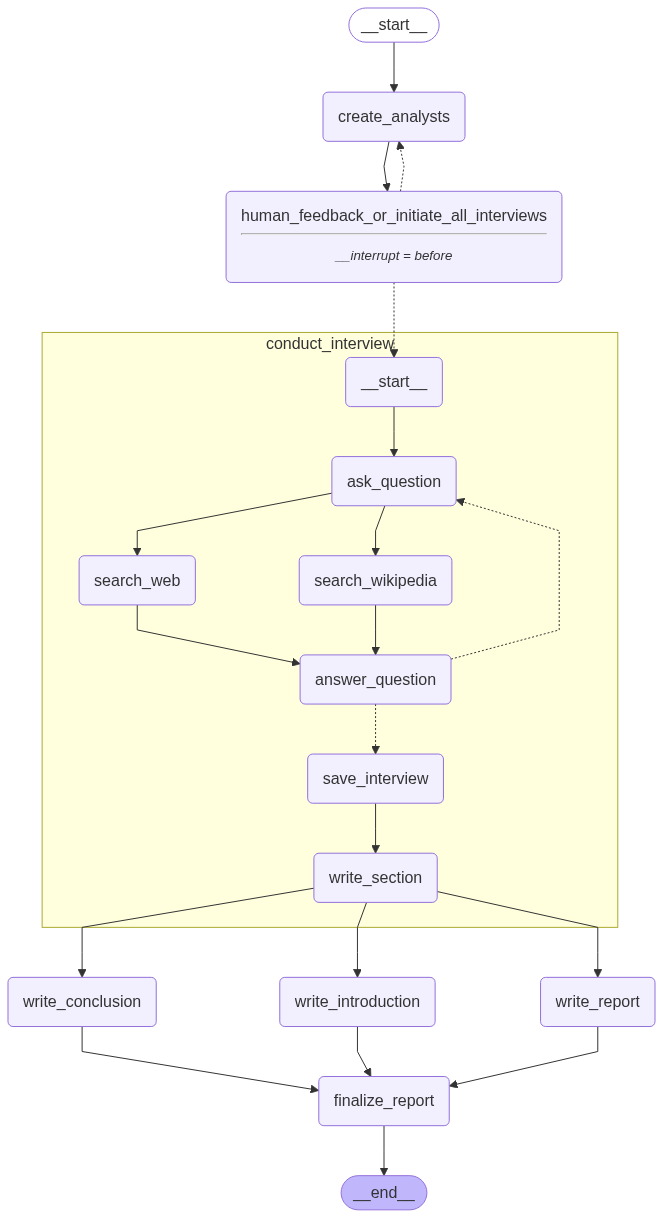

In [ ]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
# builder.add_node("human_feedback", human_feedback)
builder.add_node("human_feedback_or_initiate_all_interviews", initiate_all_interviews)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)


builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback_or_initiate_all_interviews") 
# builder.add_edge("create_analysts", "human_feedback")
# builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_or_initiate_all_interviews'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [199]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Cartwright
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Cartwright focuses on the technical advantages of adopting LangGraph, emphasizing its compatibility with existing systems and its ability to enhance data parsing efficiency.
--------------------------------------------------
Name: Mr. Alan Foster
Affiliation: Future Tech Research Group
Role: Market Analyst
Description: Mr. Foster evaluates the market landscape for AI frameworks and investigates LangGraph's positioning among competitors, highlighting its potential for cost-reduction and improved productivity.
--------------------------------------------------
Name: Prof. Sarah Chen
Affiliation: Academic Research Collaborative
Role: Ethics and Governance Analyst
Description: Prof. Chen examines the ethical implications and governance considerations of using LangGraph as an agent framework, ensuring compliance with regulatory standards and promoting responsible AI use.
------------

In [200]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
    "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05c442-96c9-611e-8002-cae17971c8b8'}}

In [201]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Cartwright
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Cartwright focuses on the technical advantages of adopting LangGraph, emphasizing its compatibility with existing systems and its ability to enhance data parsing efficiency.
--------------------------------------------------
Name: Mr. Alan Foster
Affiliation: Future Tech Research Group
Role: Market Analyst
Description: Mr. Foster evaluates the market landscape for AI frameworks and investigates LangGraph's positioning among competitors, highlighting its potential for cost-reduction and improved productivity.
--------------------------------------------------
Name: Prof. Sarah Chen
Affiliation: Academic Research Collaborative
Role: Ethics and Governance Analyst
Description: Prof. Chen examines the ethical implications and governance considerations of using LangGraph as an agent framework, ensuring compliance with regulatory standards and promoting responsible AI use.
------------

In [202]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
    None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05c442-b3ce-68a4-8004-04a19790c369'}}

In [203]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [204]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unlocking the Future of AI with LangGraph

## Introduction

In today's rapidly advancing landscape of artificial intelligence, the integration of innovative frameworks like LangGraph is essential for maximizing operational efficiency. This report explores how LangGraph revolutionizes AI application development through its unique graph-based architecture, enabling seamless multi-agent coordination and stateful processing. By fostering transparency and enhancing adaptability, LangGraph empowers businesses to build robust, scalable solutions that can evolve with dynamic demands. Additionally, a comparative analysis highlights its advantages over traditional frameworks, showcasing LangGraph as a transformative asset for startups and enterprises aiming to leverage AI effectively. Explore the myriad benefits and real-world applications that position LangGraph at the forefront of AI innovation.

---


The adoption of LangGraph as an agent framework offers a multitude of benefits for organizations looking to harness the potential of artificial intelligence in a rapidly evolving tech landscape. As an innovative framework, LangGraph supports the creation of stateful multi-agent systems that excel in managing complex workflows and enhancing operational efficiency.

LangGraph stands out due to its graph-based architecture, which allows for seamless integration of structured workflows with flexible operations, enabling developers to create robust AI solutions that mimic intelligent agent behaviors ([1](https://www.reddit.com/r/LLMDevs/comments/1jip6sm/why_we_chose_langgraph_to_build_our_coding_agent/), [6](https://medium.com/@jackpritomsoren/langchain-and-langgraph-the-building-blocks-for-modern-ai-applications-05d028759578)). This architecture's ability to support stateful, iterative processes and multi-agent coordination significantly reduces development time for complex applications, empowering organizations to respond swiftly to market changes ([2](https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03), [3](https://www.langchain.com/langgraph)).

One of the key differentiators of LangGraph is its focus on transparency within AI workflows, which facilitates the tracking of agent performance and decision-making processes. This transparency enhances debugging capabilities and fosters trust in AI-engineered applications, bridging the gap between raw execution and user experience ([5](https://www.ibm.com/think/topics/langgraph)). Additionally, the integration with established tools for observability, such as OpenTelemetry, enhances real-time tracking of agent actions and decision pathways, contributing to improved performance metrics and data integrity ([1](https://www.analyticsvidhya.com/blog/2024/07/ai-agent-frameworks/), [2](https://last9.io/blog/langchain-langgraph-the-frameworks-powering-production-ai-agents/)).

LangGraph's open-source nature encourages a community-driven approach, allowing developers to innovate rapidly and share best practices, thus advancing the framework's capabilities further than traditional proprietary systems can achieve. The collaborative workflows enabled by LangGraph's conversational AI capabilities empower multiple agents to work on shared tasks, thereby improving response times and user satisfaction in critical applications ([3](https://medium.com/@iamanraghuvanshi/agentic-ai-3-top-ai-agent-frameworks-in-2025-langchain-autogen-crewai-beyond-2fc3388e7dec), [4](https://medium.com/@garima_yadav/real-world-applications-and-case-studies-with-langgraph-from-theory-to-practice-7a6ffd2e8e1b)).

Moreover, LangGraph is designed to manage intricate workflows in ways that many traditional frameworks struggle to handle, thus positioning itself competitively against other frameworks like CrewAI and OpenAI Swarm. This adaptability allows organizations to develop applications that can intelligently respond to changing scenarios, enhancing both user experience and operational efficiency ([1](https://www.relari.ai/blog/ai-agent-framework-comparison-langgraph-crewai-openai-swarm), [2](https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4)).

In summary, LangGraph's robust features—from multi-agent coordination and transparency to customization and collaborative workflows—make it a powerful tool for startups and enterprises alike. Its applicability across various sectors, such as customer service and travel, underscores its potential to drive effective AI-driven transformations and deliver significant advantages in today's competitive landscape.


---

## Conclusion

In summary, adopting LangGraph as an agent framework offers transformative benefits for businesses seeking to enhance operational efficiency and innovation. With its graph-based architecture, LangGraph facilitates the creation of stateful, multi-agent systems that can adeptly navigate complex workflows, unlike traditional frameworks. The integration with observability tools promotes transparency, enabling robust performance tracking. Further, its open-source nature and support for cyclical workflows empower developers to innovate and collaborate effectively. As demonstrated through real-world applications, LangGraph stands poised to redefine how enterprises utilize AI, making it a critical asset in today’s digital landscape.

## Sources
[1] https://www.reddit.com/r/LLMDevs/comments/1jip6sm/why_we_chose_langgraph_to_build_our_coding_agent/  
[2] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[3] https://www.langchain.com/langgraph  
[4] https://www.ibm.com/think/topics/langgraph  
[5] https://medium.com/@jackpritomsoren/langchain-and-langgraph-the-building-blocks-for-modern-ai-applications-05d028759578  
[6] https://www.analyticsvidhya.com/blog/2024/07/ai-agent-frameworks/  
[7] https://last9.io/blog/langchain-langgraph-the-frameworks-powering-production-ai-agents/  
[8] https://medium.com/@iamanraghuvanshi/agentic-ai-3-top-ai-agent-frameworks-in-2025-langchain-autogen-crewai-beyond-2fc3388e7dec  
[9] https://medium.com/@garima_yadav/real-world-applications-and-case-studies-with-langgraph-from-theory-to-practice-7a6ffd2e8e1b  
[10] https://blog.premai.io/open-source-agentic-frameworks-langgraph-vs-crewai-more/  
[11] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  
[12] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4

In [32]:
from langsmith import traceable
from langchain_openai import ChatOpenAI
import uuid
llm = ChatOpenAI(model="gpt-4.1")
thread_id = uuid.uuid4()

In [37]:
@traceable(
    metadata={"thread_id": thread_id}
)
def app(question):
    response = llm.invoke(question)
    return response.content

In [38]:
app("how are you doing?")

"I'm doing well, thank you for asking! How can I assist you today? 😊"

In [ ]:
from langsmith import Client
client = Client()

In [41]:
example_inputs = [
("How do I set up tracing to LangSmith if I'm using LangChain?", "To set up tracing to LangSmith while using LangChain, you need to set the environment variable `LANGSMITH_TRACING` to 'true'. Additionally, you must set the `LANGSMITH_API_KEY` environment variable to your API key. By default, traces will be logged to a project named \"default.\""),
("How can I trace with the @traceable decorator?", "To trace with the @traceable decorator in Python, simply decorate any function you want to log traces for by adding `@traceable` above the function definition. Ensure that the LANGSMITH_TRACING environment variable is set to 'true' to enable tracing, and also set the LANGSMITH_API_KEY environment variable with your API key. By default, traces will be logged to a project named \"default,\" but you can configure it to log to a different project if needed."),
("How do I pass metadata in with @traceable?", "You can pass metadata with the @traceable decorator by specifying arbitrary key-value pairs as arguments. This allows you to associate additional information, such as the execution environment or user details, with your traces. For more detailed instructions, refer to the LangSmith documentation on adding metadata and tags."),
("What is LangSmith used for in three sentences?", "LangSmith is a platform designed for the development, monitoring, and testing of LLM applications. It enables users to collect and analyze unstructured data, debug issues, and create datasets for testing and evaluation. The tool supports various workflows throughout the application development lifecycle, enhancing the overall performance and reliability of LLM applications."),
("What testing capabilities does LangSmith have?", "LangSmith offers capabilities for creating datasets of inputs and reference outputs to run tests on LLM applications, supporting a test-driven approach. It allows for bulk uploads of test cases, on-the-fly creation, and exporting from application traces. Additionally, LangSmith facilitates custom evaluations to score test results, enhancing the testing process."),
("Does LangSmith support online evaluation?", "Yes, LangSmith supports online evaluation as a feature. It allows you to configure a sample of runs from production to be evaluated, providing feedback on those runs. You can use either custom code or an LLM as a judge for the evaluations."),
("Does LangSmith support offline evaluation?", "Yes, LangSmith supports offline evaluation through its evaluation how-to guides and features for managing datasets. Users can manage datasets for offline evaluations and run various types of evaluations, including unit testing and auto-evaluation. This allows for comprehensive testing and improvement of LLM applications."),
("Can LangSmith be used for finetuning and model training?", "Yes, LangSmith can be used for fine-tuning and model training. It allows you to capture run traces from your deployment, query and filter this data, and convert it into a format suitable for fine-tuning models. Additionally, you can create training datasets to keep track of the data used for model training."),
("Can LangSmith be used to evaluate agents?", "Yes, LangSmith can be used to evaluate agents. It provides various evaluation strategies, including assessing the agent's final response, evaluating individual steps, and analyzing the trajectory of tool calls. These methods help ensure the effectiveness of LLM applications."),
("How do I create user feedback with the LangSmith sdk?", "To create user feedback with the LangSmith SDK, you first need to run your application and obtain the `run_id`. Then, you can use the `create_feedback` method, providing the `run_id`, a feedback key, a score, and an optional comment. For example, in Python, it would look like this: `client.create_feedback(run_id, key=\"feedback-key\", score=1.0, comment=\"comment\")`."),
]

In [ ]:
dataset_id = "125bbf47-e403-4916-a812-cdc196a9dbf7"

# Prepare inputs and outputs for bulk creation
inputs = [{"question": input_prompt} for input_prompt, _ in example_inputs]
outputs = [{"output": output_answer} for _, output_answer in example_inputs]

client.create_examples(
  inputs=inputs,
  outputs=outputs,
  dataset_id=dataset_id,
)

{'example_ids': ['9f5865d3-cabd-4588-8b34-c3d5b105d25a',
  'b4cfdba9-00e9-49cb-ba35-e8f6925e41b7',
  'a5b0e288-4c4a-45c8-8bd0-f29f7e6b9968',
  'eb03bacf-dac2-428e-baec-f6e88311cd91',
  '06a884b3-b1a4-4275-9538-d2747f86ba34',
  '801aa97b-2b6e-4ca9-a6b9-d7042980273d',
  'c7bb9c31-f9c8-4488-b15f-08b53e8d65ab',
  'f037f344-e358-4135-b1b9-30ce03148def',
  '07ed3b36-72ab-4c64-ae2e-78884b6244a3',
  'e0f75ec5-c56a-4536-8c92-1d8c66c31db8'],
 'count': 10}